In [1]:
from random import randrange

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# from torchvision.datasets import MNIST
# from torchvision.datasets import FashionMNIST
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

In [2]:
class MnistModel(nn.Module):
    def __init__(self, r1):
        super().__init__()
        self.r1 = r1
        self.linear = nn.Linear(self.r1.input_size, self.r1.num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, self.r1.input_size)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = self.r1.accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["val_loss"], result["val_acc"]
            )
        )

In [3]:
class Logistic_regression:
    def __init__(self):
        print("constructor")

    def init_hyp(self):
        self.batch_size = 128
        self.lr = 0.1
        self.epoch = 5

    def get_data(self):
        #         self.Dataset = MNIST
        #         self.Dataset = FashionMNIST
        self.Dataset = CIFAR10
        self.dataset = self.Dataset(
            root="data/", train=True, transform=transforms.ToTensor(), download=True
        )
        self.input_size = np.prod(self.dataset[0][0].shape)
        self.num_classes = len(self.dataset.classes)

    def init_data(self):
        self.get_data()
        self.init_hyp()
        self.model = MnistModel(self)

        train_ds, val_ds = random_split(
            self.dataset, [int(len(self.dataset) * 0.8), int(len(self.dataset) * 0.2)]
        )
        self.test_ds = self.Dataset(
            root="data/", train=False, transform=transforms.ToTensor()
        )

        self.train_loader = DataLoader(train_ds, self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_ds, self.batch_size * 2)
        self.test_loader = DataLoader(self.test_ds, self.batch_size * 2)

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def evaluate(self, data):
        outputs = [self.model.validation_step(batch) for batch in data]
        return self.model.validation_epoch_end(outputs)

    def fit(self, opt_func=torch.optim.SGD):
        self.history = []
        optimizer = opt_func(self.model.parameters(), self.lr)
        for e in range(self.epoch):
            for batch in self.train_loader:
                loss = self.model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Validation phase
            result = self.evaluate(self.val_loader)
            self.model.epoch_end(e, result)
            self.history.append(result)

    def plot_acc(self):
        accuracies = [r["val_acc"] for r in self.history]
        plt.plot(accuracies, "-x")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.title("Accuracy vs. No. of epochs")

    def predict_rand_image(self):
        img_i = randrange(0, len(self.test_ds), 1)
        img, label = self.test_ds[img_i]
        print(img.shape)
        plt.imshow(img.permute(1, 2, 0))
        print(
            "Label:",
            self.test_ds.classes[label],
            ", Predicted:",
            self.test_ds.classes[self.predict_image(img)],
        )

    def predict_image(self, img):
        xb = img.unsqueeze(0)
        yb = self.model(xb)
        _, preds = torch.max(yb, dim=1)
        return preds[0].item()

    def display_batch(self):
        for images, _ in self.train_loader:
            print("images.shape:", images.shape)
            plt.figure(figsize=(16, 8))
            plt.axis("off")
            plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
            break

In [4]:
r1 = Logistic_regression()

constructor


In [5]:
r1.init_data()

Files already downloaded and verified


In [6]:
r1.evaluate(r1.test_loader)

{'val_loss': 2.345388412475586, 'val_acc': 0.09580077975988388}

images.shape: torch.Size([128, 3, 32, 32])


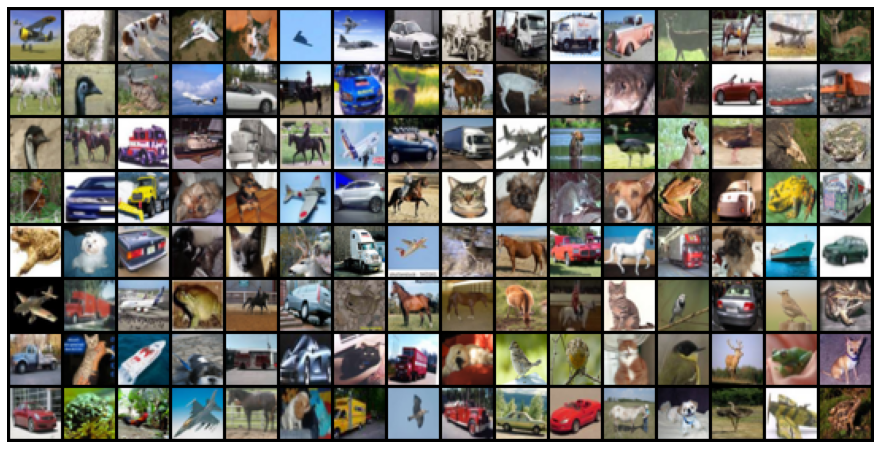

In [7]:
r1.display_batch()

In [8]:
r1.fit()

Epoch [0], val_loss: 12.3117, val_acc: 0.2522
Epoch [1], val_loss: 10.9948, val_acc: 0.2285
Epoch [2], val_loss: 11.1042, val_acc: 0.1892
Epoch [3], val_loss: 8.9493, val_acc: 0.2082
Epoch [4], val_loss: 10.4246, val_acc: 0.2571


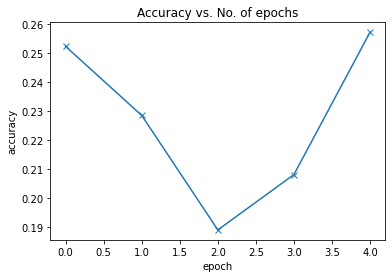

In [9]:
r1.plot_acc()

In [10]:
r1.evaluate(r1.test_loader)

{'val_loss': 10.354744911193848, 'val_acc': 0.2587890625}

torch.Size([3, 32, 32])
Label: horse , Predicted: horse


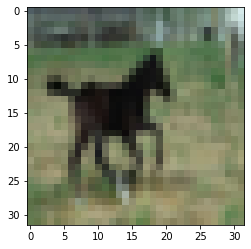

In [11]:
r1.predict_rand_image()